In [30]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

In [31]:
src_dir = r'C:\Users\HP\Desktop\Oreilly\Blue Team\Captcha Solver\captcha_images'
img_paths = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg'))]

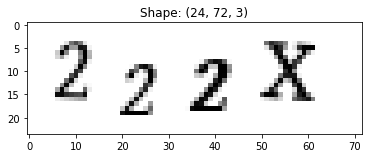

In [32]:
img = cv2.imread(os.path.join(src_dir, img_paths[0]))
plt.imshow(img)
plt.title(f'Shape: {img.shape}')
plt.show()

In [33]:
# Get list of ground-truth labels from image filenames
labels = [img_path.split('.')[0] for img_path in img_paths]

# Get count of each unique char
char_counts = {}
for label in labels:
    for char in label:
        if char not in char_counts:
            char_counts[char] = 1
        else:
            char_counts[char] += 1
            
# Sort by character
char_counts = sorted(char_counts.items())
# Convert items to two stand-alone lists
chars = [char_count[0] for char_count in char_counts]
counts = [char_count[1] for char_count in char_counts]
# Want first char on top, so reverse order
chars.reverse()
counts.reverse()

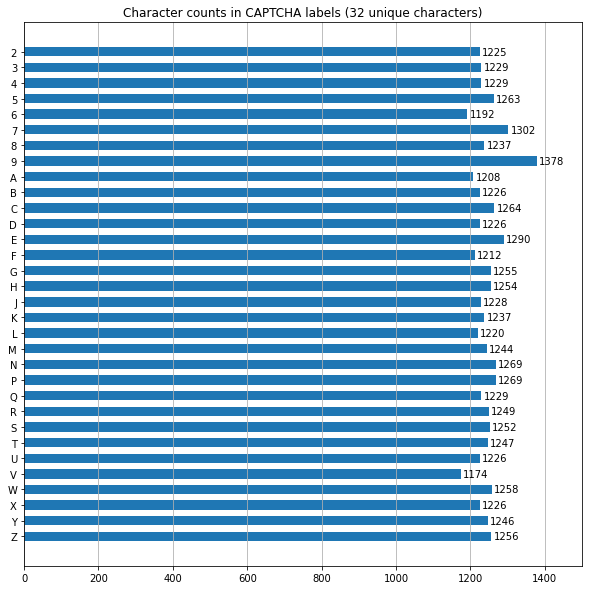

In [34]:
plt.figure(figsize=(10, 10))

bars = plt.barh(y=chars, width=counts, height=0.6)
for bar in bars:
    w = bar.get_width()
    y = bar.get_y()
    h = bar.get_height()
    plt.text(w+40, y+h/2, w, ha='center', va='center')
    
plt.xlim(0, 1500)
plt.grid(linestyle='-', axis='x')
plt.title(f'Character counts in CAPTCHA labels ({len(chars)} unique characters)')
plt.show()

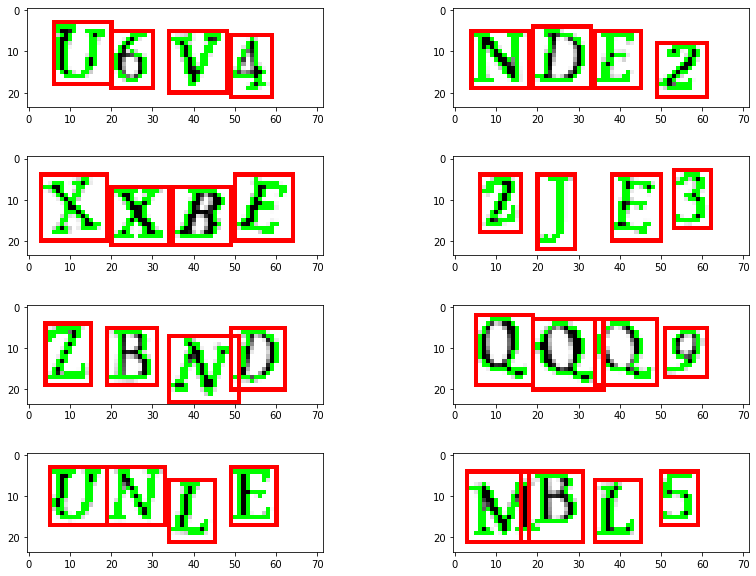

In [35]:
fig = plt.figure(figsize=(14, 10))

plt_rows = 4
plt_cols = 2
plt_iter = 1

plt.subplots_adjust(hspace=0.5)

for i in range(plt_rows*plt_cols):
    plt.subplot(plt_rows, plt_cols, plt_iter)
    
    img_index = np.random.randint(0, len(img_paths))
    # Load random image
    img = cv2.imread(os.path.join(src_dir, img_paths[img_index]))
    # Covert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take binary threshold
    ret, thresh = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    # Invert image
    bit_not = cv2.bitwise_not(thresh)
    # Find contours
    contours, hierarchy = cv2.findContours(bit_not, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Draw on orignal image
    cv2.drawContours(img, contours, -1, (0, 255, 0), 1)
    # Get bounding rect of each contour
    rects = [cv2.boundingRect(c) for c in contours]
    # Sort rects by their width
    rects.sort(key=lambda x: x[2])
    
    # Deal with touching letters where one wide bounding box
    # envlopes two letters. split these in half
    while len(rects) < 4:
        # Pop widest rect
        wide_rect = rects.pop()
        x, y, w, h = wide_rect
        # Split in two
        first_half = (x, y, w//2, h)
        second_half = (x+w//2, y, w//2, h)
        rects.append(first_half)
        rects.append(second_half)
        # Re-sort rects by their width
        rects.sort(key=lambda x: x[2])
    
    for rect in rects:
        x, y, w, h = rect
        # Buffer rect by 1 pixel
        cv2.rectangle(img, (x-1, y-1), (x+w+1, y+h+1), (255, 0, 0), 1)
    
    plt.imshow(img)
    plt_iter += 1

In [36]:
class Segmenter:
    '''
    Methods
    -------
    segment_chars(img_path, plot=False):
        Utilizes OpenCV findContours() to extract bounding rectangles of
        characters within a CAPTCHA image
    plot_segmented_chars(img, segmented_chars):
        Plot image and segmented characters side-by-side
    '''
    def segment_chars(self, img_path: str, plot=False) -> list:
        '''
        Utilizes OpenCV findContours() to extract bounding rectangles of
        characters within a CAPTCHA image
        Parameters
        ----------
        img_path : str
            Path to CAPTCHA image to segment into characters
        plot : bool, default: False
            Option to plot the CAPTCHA segmentation results
        Returns
        -------
        segmented_chars : list
            List of (char_img, label) tuples
        '''
        img = cv2.imread(img_path)
        # covert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # take binary threshold
        ret, thresh = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
        # invert image
        bit_not = cv2.bitwise_not(thresh)
        # find contours
        contours, hierarchy = cv2.findContours(bit_not, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # get bounding rect of each contour
        rects = [cv2.boundingRect(c) for c in contours]
        # sort rects by their width
        rects.sort(key=lambda x: x[2])

        # deal with touching letters where one wide bounding box
        # envlopes two letters. split these in half
        while len(rects) < 4:
            # pop widest rect
            wide_rect = rects.pop()
            x, y, w, h = wide_rect
            # split in two
            first_half = (x, y, w//2, h)
            second_half = (x+w//2, y, w//2, h)
            rects.append(first_half)
            rects.append(second_half)
            # re-sort by width
            rects.sort(key=lambda x: x[2])

        if len(rects) > 4:
            print('For some reason more than 4 characters were identified in '
                  'the CAPTCHA! Returning the widest four...')
            rects = rects[-4:]

        # sort rects by horizontal position left to right
        rects.sort(key=lambda x: x[0])
        # define labels using each char from filename string
        labels = [char for char in os.path.basename(img_path).split('.')[0]]

        # use bounding rects to crop each character from the image array
        segmented_chars = []
        for rect, label in zip(rects, labels):
            x, y, w, h = rect

            # buffer char's bounding rect by one pixel if possible
            if x > 0:
                x -= 1
            if y > 0:
                y -= 1
            if x+w < img.shape[1]:
                w += 1
            if y+h < img.shape[0]:
                h += 1

            char_img = img[y:y+h, x:x+w, :]
            segmented_chars.append((char_img, label))

        if plot:
            self.plot_segmented_chars(img, segmented_chars)

        return segmented_chars


    def plot_segmented_chars(self, img, segmented_chars):
        '''
        Plot image and segmented characters side-by-side.
        Parameters
        ----------
        img : np.array
            CATPCHA image array
        segmented_chars: list
            List of (char_img, label) tuples
        '''

        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
            1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [4, 1, 1, 1, 1]}
        )
        ax1.imshow(img)
        char_imgs = [segmented_char[0] for segmented_char in segmented_chars]
        ax2.imshow(char_imgs[0])
        ax3.imshow(char_imgs[1])
        ax4.imshow(char_imgs[2])
        ax5.imshow(char_imgs[3])

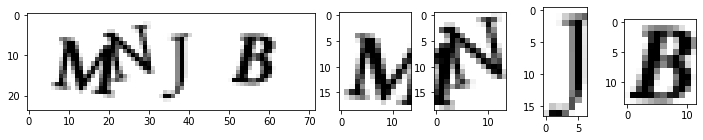

In [37]:
# Demonstrate on random image
img_index = np.random.randint(0, len(img_paths))

Segmenter1 = Segmenter()
segmented_chars = Segmenter1.segment_chars(os.path.join(src_dir, img_paths[img_index]), plot=True)

In [38]:
import os
import shutil
import random
import pandas as pd
import cv2

class DataGenerator:
    '''
    Data generator that takes a directory of CAPTCHA images and spits them out
    into directories for training and testing sets
    Parameters
    ----------
    src_dir : str
        path to directory that contains CAPTCHA images, image files must be
        named with their CAPTCHA text
    random_seed : int, default=1
        integer seed to set random.seed()
    train_size : float, default=0.75
        size of training set to be extracted, range from 0.0 - 1.0
    Attributes
    ----------
    train_img_paths : list
        List of paths to character training images
    test_img_paths : list
        List of paths to CAPTCHA test images
    label_dict : dict
        Dictionary containing (alphanumeric character: integer label) items for
        each character in the training set
    Segmenter : .segmenter.Segmenter
        Instance of the .segmeneter.Segmenter class to segmenting test images
    Methods
    -------
    extract_train_set(target_dir, train_annotation_file='train_annotations.csv'):
        Uses Segmenter class to extract individual characters from directory of
        CAPTCHA images
    save_test_set(target_dir):
        Copy over test set images to target directory
    save_label_dict(target_path):
        Save label dictionary of integer labels of alphanumeric characters
        within CAPTCHA images to a CSV
    '''
    def __init__(self, src_dir, train_size=0.75, random_seed=None):
        if random_seed:
            random.seed(random_seed)

        img_paths = [
            os.path.join(src_dir, path) for path in os.listdir(src_dir)
            if path.lower().endswith(('.jpg', '.png'))
        ]

        random.shuffle(img_paths)
        split_index = int(len(img_paths) * train_size)
        self.train_img_paths = img_paths[:split_index]
        self.test_img_paths = img_paths[split_index:]

        # generate list of all characters in CAPTCHA images
        all_chars = []
        for img_path in img_paths:
            chars = os.path.basename(img_path).split('.')[0]
            for char in chars:
                all_chars.append(char)
        unique_chars = sorted(list(set(all_chars)))
        # assign integer label to each unique character
        self.label_dict = {char: i for i, char in enumerate(unique_chars)}

        self.Segmenter = Segmenter()


    def extract_train_set(self, target_dir, train_annotation_file='train_annotations.csv'):
        '''
        Uses Segmenter class to extract individual characters from directory of
        set CAPTCHA images, these char images serve as training data for the
        character classification model
        Parameters
        ----------
        target_dir : str
            Path for new directory, or empty directory, to contain character
            training images extracted from the trianing CAPTCHA images
        train_annotation_file : str, default=train_annotations.csv
            Path to annotations CSV file of training data, with each row
            containing (filename, label)
        '''

        if os.path.isdir(target_dir) == False:
            os.mkdir(target_dir)
        elif len([f for f in os.listdir(target_dir)
                  if f.lower().startswith(('.png', '.jpg'))]) > 0:
            raise ValueError(
                'target_dir needs to be a new directory or an existing directory'
                'free of image files'
            )

        # initialize list that will collect list of dictionaries to be record
        # annotations for each training example
        annotation_rows = []

        print(f'Segmenting chars from {len(self.train_img_paths)} images...')

        i = 0
        for img_path in self.train_img_paths:
            segmented_chars = self.Segmenter.segment_chars(img_path)

            for segmented_char in segmented_chars:
                if i % 2000 == 0:
                    print(f'Working on char {i}...')

                char_img, label = segmented_char
                # generate arbitrary numeric filename for each character
                target_img_fn = str(i).zfill(6)+'.png'
                try:
                    # write segmented character image to target directory
                    cv2.imwrite(os.path.join(target_dir, target_img_fn), char_img)
                    # use char label to lookup corresponding integer label
                    int_label = self.label_dict[label]
                    annotation_rows.append({'filename': target_img_fn, 'label': int_label})
                    i += 1
                except cv2.error as e:
                    print('\n*************************'
                          '\nFailed to write image with cv2.error:')
                    print(e)
                    continue

        annotation_df = pd.DataFrame(annotation_rows)
        annotation_df.to_csv('train_annotations.csv', index=False)
        print(f'Done! Saving filename/numeric class label key to file: {train_annotation_file}')


    def save_test_set(self, target_dir: str):
        '''
        Copy over test set images to target directory
        These will remain unsegmented/unaltered so the model can be evaluated on
        entirely unseen data
        '''
        if os.path.isdir(target_dir) == False:
            os.mkdir(target_dir)
        elif len([f for f in os.listdir(target_dir)
                  if f.lower().startswith(('.png', '.jpg'))]) > 0:
            raise ValueError(
                'target_dir needs to be a new directory or an existing directory'
                'free of image files'
            )

        print(f'Copying {len(self.test_img_paths)} images to {target_dir}...')

        for img_path in self.test_img_paths:
            target_path = os.path.join(target_dir, os.path.basename(img_path))
            shutil.copy(img_path, target_path)

        print(f'Copied {len(self.test_img_paths)} images to {target_dir}')


    def save_label_dict(self, target_path):
        '''
        Save label dictionary of integer labels of alphanumeric characters
        within CAPTCHA images to a CSV
        '''
        label_dict_items = self.label_dict.items()
        label_list = list(label_dict_items)
        label_df = pd.DataFrame(label_list, columns=['char', 'int'])
        label_df.to_csv(target_path, index=False)

In [39]:
DataGenerator1 = DataGenerator(src_dir, train_size=0.75, random_seed=1)

In [40]:
DataGenerator1.extract_train_set('train', train_annotation_file=r'train_annotations.csv')

Segmenting chars from 7466 images...
Working on char 0...
Working on char 2000...
Working on char 4000...
Working on char 6000...
Working on char 8000...
Working on char 10000...
Working on char 12000...
Working on char 14000...
Working on char 16000...
Working on char 18000...
Working on char 20000...
Working on char 22000...
Working on char 24000...
Working on char 26000...
Working on char 28000...
Done! Saving filename/numeric class label key to file: train_annotations.csv


In [41]:
DataGenerator1.save_test_set('test')

Copying 2489 images to test...
Copied 2489 images to test


In [42]:
DataGenerator1.save_label_dict(r'label_key.csv')

In [43]:
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset

class CharsDataset(Dataset):
    '''
    Custom PyTorch Dataset to load in individual character images segmented
    from CAPTCHA images
    Parameters
    ----------
    annotations_path : str
        Path to annotations CSV file of training data, with each row
        containing (filename, label)
    root_dir : str
        Path to directory containing segmented character training images
    Attributes
    ----------
    annotations : pandas.DataFrame
        Pandas DataFrame with character image filenames (column 0, named
        'filenames') and their corresponding integer labels (column 1, named
        'label')
    root_dir : str
        Path to the directory which contains the character training images
    transform :
    Methods
    -------
    __len__():
        Returns the length of the training dataset
    __getitem__():
        Returns the next (img, y_label) tuple, with the img as a transformed
        tensor
    '''
    def __init__(self, annotations_path, root_dir):
        self.annotations = pd.read_csv(annotations_path)
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Grayscale(), # 3-band to 1-band
            transforms.Resize((15, 12)), # average size of each char image
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        img = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        img = self.transform(img)

        return (img, y_label)

In [45]:
from torch.utils.data import random_split, DataLoader
CharsDataset1 = CharsDataset(r'train_annotations.csv', 'train')

In [46]:
round(len(CharsDataset1)*0.8)

23891

In [47]:
train_set, val_set = random_split(CharsDataset1, [24000, len(CharsDataset1)-24000])

In [48]:
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=True)

In [50]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable

In [51]:
from torch.nn import (
    Module,
    Sequential,
    Conv2d,
    BatchNorm2d,
    ReLU,
    MaxPool2d,
    Linear,
    LogSoftmax
)

class Model(Module):
    '''Convolutional neural network architecture, loosely based on LeNet'''
    def __init__(self):
        super(Model, self).__init__()

        self.cnn_layers = Sequential(
            # first conv layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # second conv layer, no pooling
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
        )

        self.linear_layers = Sequential(
            Linear(168, 64),
            ReLU(inplace=True),
            Linear(64, 32),
            LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)

        return x

In [52]:
Model1 = Model()
val_iter = iter(val_loader)

In [53]:
optimizer = Adam(Model1.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
epochs = 5

In [54]:
# Training and validation of model

# Will accumulate loss for learning curve plot
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):        
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x (char image)
        b_y = Variable(y)   # batch y (target label, as int)
        output = Model1(b_x)
        loss = criterion(output, b_y) 
        train_loss_history.append(loss.data)
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()
        
        # Evaluate on validation set every 50 batches
        if step % 50 == 0:
            val_x, val_y = next(val_iter)
            val_output = Model1(val_x)
            val_loss = criterion(val_output, val_y)
            val_loss_history.append(val_loss.data)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| val loss: %.4f' % val_loss.data)

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:  0 | train loss: 3.4349 | val loss: 3.5280
Epoch:  0 | train loss: 2.3467 | val loss: 2.5946
Epoch:  0 | train loss: 0.9463 | val loss: 0.9507
Epoch:  0 | train loss: 0.4394 | val loss: 0.3650
Epoch:  0 | train loss: 0.1317 | val loss: 0.1583
Epoch:  0 | train loss: 0.0886 | val loss: 0.4817
Epoch:  0 | train loss: 0.0938 | val loss: 0.0670
Epoch:  0 | train loss: 0.2592 | val loss: 0.1441
Epoch:  0 | train loss: 0.0390 | val loss: 0.0598
Epoch:  0 | train loss: 0.2116 | val loss: 0.0723
Epoch:  0 | train loss: 0.0253 | val loss: 0.0448
Epoch:  0 | train loss: 0.0230 | val loss: 0.1440
Epoch:  0 | train loss: 0.0218 | val loss: 0.0540
Epoch:  0 | train loss: 0.0259 | val loss: 0.0772
Epoch:  0 | train loss: 0.0346 | val loss: 0.1322
Epoch:  1 | train loss: 0.1787 | val loss: 0.0152
Epoch:  1 | train loss: 0.1923 | val loss: 0.0207
Epoch:  1 | train loss: 0.0224 | val loss: 0.0245
Epoch:  1 | train loss: 0.0161 | val loss: 0.0209
Epoch:  1 | train loss: 0.0078 | val loss: 0.0459


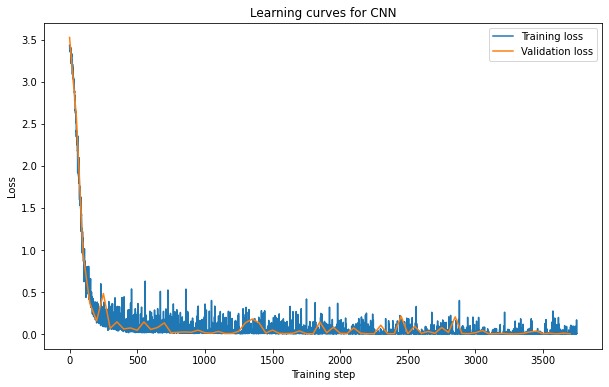

In [55]:
# Plotting learning curve

train_loss_history_x = np.arange(0, len(train_loss_history))

# Only have validation loss every 50 batches
val_loss_history_x = np.arange(0, len(val_loss_history)*50, 50)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history_x, train_loss_history, label='Training loss')
plt.plot(val_loss_history_x, val_loss_history, label='Validation loss')
plt.legend()
plt.title('Learning curves for CNN')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.show()

In [57]:
# Save state dictionary of trained model
torch.save(Model1.state_dict(), 'Model_state_dict.pt')

In [58]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

class Evaluator:
    '''
    Class to evaluate the segmentation system and trained model on the test set
    of CAPTCHA images
    Attributes
    ----------
    Model : .model.Model
        PyTorch model, instance of the .model.Model class
    transform : PyTorch transforms
        PyTorch transforms chained together with torchvision.transforms.Compose()
    Segmenter : .segmenter.Segmenter
        Instance of the .segmenter.Segmenter class to segment characters from
        CAPTCHAs
    label_dict : dict
        Path to PyTorch state_dict file (typically .pt or .pth extension) to
        load the trained state of a model
    Methods
    -------
    predict():
        Use trained model to make a prediction on a CAPTCHA image
    evaluate_test_set():
        Evalute trained model on a test set of CAPTCHA images
    '''
    def __init__(self, Model, transform, label_key, model_state_dict=None):
        self.Model = Model
        if model_state_dict:
            self.Model.load_state_dict(torch.load(model_state_dict))
        self.Model.eval()

        self.transform = transform
        self.Segmenter = Segmenter()

        # Read in label_key CSV file that was made during data generation
        label_key_df = pd.read_csv(label_key)
        # Convert to dictionary with (int: char) items
        self.label_dict = pd.Series(
            label_key_df.char.values,
            index=label_key_df.int
        ).to_dict()


    def predict(self, img_path, print_results=False, plot_segmentation=False):
        '''Use trained model to make a prediction on a CAPTCHA image'''
        # Segment CAPTCHA image into characters
        segmented_chars = self.Segmenter.segment_chars(img_path, plot=plot_segmentation)

        # Predict on each character
        predictions = []
        for segmented_char in segmented_chars:
            x, y = segmented_char
            x = Image.fromarray(x) # to PIL image
            x = self.transform(x) # Apply Dataset transformations
            prediction = self.Model(x.unsqueeze(0))
            y_hat = torch.max(prediction, 1)[1].data.squeeze()
            # Convert integer prediction to character using label dict
            y_hat = self.label_dict[y_hat.item()]

            if print_results:
                print(f'Predicted: {y_hat} | Actual: {y}')

            predictions.append((y_hat, y))

        return predictions


    def evaluate_test_set(self, src_dir):
        '''Evalute trained model on a test set of CAPTCHA images'''
        test_img_paths = [os.path.join(src_dir, img_path)
                          for img_path in os.listdir(src_dir)
                          if img_path.lower().endswith(('.jpg', '.png'))]

        captcha_predictions = []
        char_predictions = []

        for test_img_path in test_img_paths:
            predictions = self.predict(test_img_path)
            char_predictions.extend(predictions)

            predicted_captcha = [''.join(chars[0] for chars in predictions)]
            actual_captcha = [''.join(chars[1] for chars in predictions)]
            captcha_predictions.append((predicted_captcha, actual_captcha))

        return EvaluatorResults(char_predictions, captcha_predictions, self.label_dict)


class EvaluatorResults:
    '''
    Results object returned by the Evaluator.evaluate_test_set() method
    Attributes
    ----------
    char_predictions : list
        List of tuples with (predicted character, actual character)
    captcha_predictions : list
        List of tuples with (predicted captcha text, actual captcha text)
    label_dict : dict
        Dictionary which contains integer character label keys, and alphanumeric
        characters (str) as values
    Methods
    -------
    plot_confusion_matrix():
        Plot a confusion matrix showing prediction results for every character
        in the test set
    '''
    def __init__(self, char_predictions, captcha_predictions, label_dict):
        self.char_predictions = char_predictions
        self.captcha_predictions = captcha_predictions
        self.label_dict = label_dict

        correct_chars = 0
        for chars in char_predictions:
            y_hat, y = chars
            if y_hat == y:
                correct_chars += 1
        self.char_accuracy = correct_chars / len(char_predictions)

        correct_captchas = 0
        for captchas in captcha_predictions:
            y_hat, y = captchas
            if y_hat == y:
                correct_captchas += 1
        self.captcha_accuracy = correct_captchas / len(captcha_predictions)


    def plot_confusion_matrix(self):
        '''
        Plot a confusion matrix showing prediction results for every character
        in the test set
        '''
        n_classes = len(self.label_dict)

        # pandas df with rows as predicted, cols as actual. initialize counts
        # with zeros
        conf_mat = pd.DataFrame(0, columns=self.label_dict.values(),
                                index=self.label_dict.values())

        for chars in self.char_predictions:
            y_hat, y = chars
            conf_mat.at[y_hat, y] += 1

        # create custom colormap for plot
        max_count = conf_mat.to_numpy().max()
        colors = cm.get_cmap('Wistia', max_count+1)
        new_colors = colors(np.arange(0, max_count+1))
        # change 0 counts to white to make matrix easier to interpret
        new_colors[0, :] = np.array([1, 1, 1, 1])
        new_cmap = ListedColormap(new_colors)

        fig, ax = plt.subplots(figsize=(12,12))
        conf_mat_plot = ax.matshow(conf_mat, cmap=new_cmap)

        # Place text with count in each cell
        for (i, j), count in np.ndenumerate(conf_mat):
            ax.text(j, i, count, ha='center', va='center')

        ax.set_xticks(np.arange(0, n_classes, 1))
        ax.set_xticklabels(list(self.label_dict.values()))
        ax.set_yticks(np.arange(0, n_classes, 1))
        ax.set_yticklabels(list(self.label_dict.values()))
        # Minor ticks, used to generate grid lines around each cell
        ax.set_xticks(np.arange(-0.5, n_classes, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, n_classes, 1), minor=True)
        ax.grid(which='minor', linestyle='-')

        cbar = plt.colorbar(conf_mat_plot, fraction=0.04, pad=0.05)

        ax.set_xlabel('Actual')
        ax.xaxis.set_label_position('top')
        ax.set_ylabel('Predicted')
        ax.set_title('Character Classification: Confusion Matrix', pad=15)

        plt.show()

In [64]:
Evaluator1 = Evaluator(Model1,
                      transform=CharsDataset1.transform,
                      label_key='label_key.csv',
                      model_state_dict='Model_state_dict.pt')

In [65]:
EvaluatorResults = Evaluator1.evaluate_test_set('test')

In [66]:
EvaluatorResults.captcha_accuracy

0.9766974688629972

In [67]:
EvaluatorResults.char_accuracy

0.9936721574929691

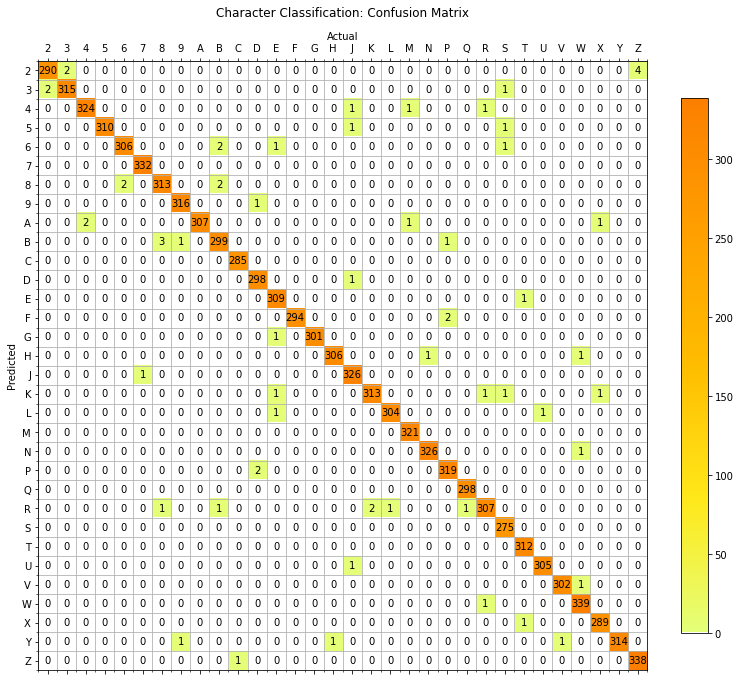

In [68]:
EvaluatorResults.plot_confusion_matrix()

Predicted: L | Actual: L
Predicted: 4 | Actual: 4
Predicted: M | Actual: M
Predicted: U | Actual: J


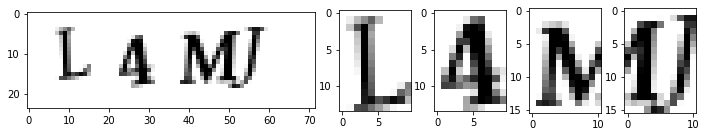

In [69]:
prediction = Evaluator1.predict(os.path.join(src_dir, 'L4MJ.png'), print_results=True, plot_segmentation=True)